In [1]:
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Clustering").getOrCreate()

In [2]:
from pyspark.sql.functions import col, when
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [3]:
data = spark.read.csv("df_RFM.csv", inferSchema=True, header=True).drop("_c0")
data.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- Monetary: double (nullable = true)
 |-- R: integer (nullable = true)
 |-- F: integer (nullable = true)
 |-- M: integer (nullable = true)
 |-- RFM_Segment: integer (nullable = true)
 |-- RFM_Score: integer (nullable = true)



In [4]:
data.show(10)

+-------------+-------+---------+--------+---+---+---+-----------+---------+
|Member_number|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|
+-------------+-------+---------+--------+---+---+---+-----------+---------+
|         2193|     91|       27|  361.45|  3|  4|  4|        344|       11|
|         1793|     26|       25|   345.1|  4|  4|  4|        444|       12|
|         3289|      4|       29|  334.15|  4|  4|  4|        444|       12|
|         2433|      3|       30|  316.81|  4|  4|  4|        444|       12|
|         2743|    142|       17|  312.46|  2|  4|  4|        244|       10|
|         2811|    310|       20|  305.72|  1|  4|  4|        144|        9|
|         2990|    140|       24|  303.61|  3|  4|  4|        344|       11|
|         3872|     37|       30|  301.33|  4|  4|  4|        444|       12|
|         4753|     52|       23|   301.1|  4|  4|  4|        444|       12|
|         2993|    239|       15|  296.96|  2|  4|  4|        244|       10|

In [5]:
data.count()

3898

In [6]:
data.describe().show()

+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+----------------+------------------+
|summary|     Member_number|           Recency|        Frequency|         Monetary|                R|                 F|                 M|     RFM_Segment|         RFM_Score|
+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+----------------+------------------+
|  count|              3898|              3898|             3898|             3898|             3898|              3898|              3898|            3898|              3898|
|   mean|3002.9599794766546| 187.7013853258081|9.882247306310928|84.89733196511037|              2.5|               2.5|               2.5|           277.5|               7.5|
| stddev| 1155.806001188376|159.91268820914237|5.269804259109583|55.34799494036805|1.118406891454291|1.1184068914542906|

In [7]:
data.columns

['Member_number',
 'Recency',
 'Frequency',
 'Monetary',
 'R',
 'F',
 'M',
 'RFM_Segment',
 'RFM_Score']

In [8]:
data.select('RFM_Score').distinct().orderBy('RFM_Score').show()

+---------+
|RFM_Score|
+---------+
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
+---------+



In [9]:
def rfm_level7(df):
    # Check for special 'STARS' and 'NEW' conditions first
    if df.RFM_Score == 12:
        return 'STARS'
    elif df.R == 4 and df.F == 1 and df.M == 1:
        return 'NEW'
    # Then check for other conditions
    elif df.M == 4:
        return 'BIG SPENDER'
    elif df.F == 4:
        return 'LOYAL'
    elif df.R == 4:
        return 'ACTIVE'
    elif df.R == 1:
        return 'LOST'
    elif df.M == 1:
        return 'LIGHT'
    else:
        return 'REGULARS'

def rfm_level6(df):
    # Best customers with highest RFM score
    if df.RFM_Score >= 11:
        return 'CHAMPIONS'
    # Loyal customers with high frequency
    elif (df.R >= 3) and (df.F >= 3) and (df.M >= 3):
        return 'LOYAL'
    # Recent customers with good potential
    elif df.R >= 3 and (df.F >= 2 or df.M >= 2):
        return 'ACTIVE'
    # High value but not recent
    elif (df.M >= 3):
        return 'BIG_SPENDER'
    # Not recent but previously active
    elif (df.F >= 2):
        return 'INACTIVE'
    # Low value and inactive customers
    else:
        return 'LOST'

def rfm_level5(df):
    # Check for high value customers
    if df.RFM_Score >= 11:
        return 'VIP'
    # Active and loyal customers
    elif (df.R >= 3) and (df.F >= 3):
        return 'LOYAL'
    # Recent customers but not frequent
    elif df.R >= 3:
        return 'ACTIVE'
    # Not recent but high value/frequency
    elif (df.F >= 3) or (df.M >= 3):
        return 'POTENTIAL'
    # Low value and inactive customers
    else:
        return 'LOST'


In [10]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import StringType

# Create UDF
rfm_level_udf = udf(rfm_level5, StringType())

# Apply the UDF to create new column
data = data.withColumn('RFM_Level', 
    rfm_level_udf(struct('RFM_Score', 'R', 'F', 'M')))

# Show results
data.show(5)

+-------------+-------+---------+--------+---+---+---+-----------+---------+---------+
|Member_number|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|RFM_Level|
+-------------+-------+---------+--------+---+---+---+-----------+---------+---------+
|         2193|     91|       27|  361.45|  3|  4|  4|        344|       11|      VIP|
|         1793|     26|       25|   345.1|  4|  4|  4|        444|       12|      VIP|
|         3289|      4|       29|  334.15|  4|  4|  4|        444|       12|      VIP|
|         2433|      3|       30|  316.81|  4|  4|  4|        444|       12|      VIP|
|         2743|    142|       17|  312.46|  2|  4|  4|        244|       10|POTENTIAL|
+-------------+-------+---------+--------+---+---+---+-----------+---------+---------+
only showing top 5 rows



In [11]:
data.groupBy('RFM_Level').count().orderBy('count', ascending=False).show()

+---------+-----+
|RFM_Level|count|
+---------+-----+
|     LOST| 1068|
|POTENTIAL|  881|
|      VIP|  676|
|   ACTIVE|  672|
|    LOYAL|  601|
+---------+-----+



In [12]:
from pyspark.sql.functions import percentile_approx, count, round, sum, col, lit

# Calculate aggregations
rfm_agg = data.groupBy('RFM_Level').agg(
    percentile_approx('Recency', 0.5).alias('RecencyMean'),
    percentile_approx('Frequency', 0.5).alias('FrequencyMean'),
    percentile_approx('Monetary', 0.5).alias('MonetaryMean'),
    count('*').alias('Count')
)

# Calculate total count for percentage
total_count = data.count()

# Add Percent column
rfm_agg = rfm_agg.withColumn('Percent', 
    round(col('Count') * 100 / lit(total_count), 2))

rfm_agg = rfm_agg.orderBy('RFM_Level')
# Show results
rfm_agg.show()

+---------+-----------+-------------+------------+-----+-------+
|RFM_Level|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|   ACTIVE|         68|            7|       53.49|  672|  17.24|
|     LOST|        337|            5|        35.1| 1068|   27.4|
|    LOYAL|         75|           11|        85.4|  601|  15.42|
|POTENTIAL|        238|           11|       96.37|  881|   22.6|
|      VIP|         40|           16|      148.52|  676|  17.34|
+---------+-----------+-------------+------------+-----+-------+



| Cụm | Số lượng | Đặc trưng tiềm năng |
|-----|----------|----------------------|
| ACTIVE | 672 | Phân khúc trung bình (17.24%), tần suất giao dịch trung bình (7.0), chi tiêu thấp (53.49), và hoạt động khá gần đây (68 ngày). Đây là nhóm khách hàng mới hoặc đang hoạt động nhưng chưa thực sự gắn kết. |
| LOST | 1068 | Phân khúc lớn nhất (27.4%), tần suất giao dịch thấp nhất (5.0), chi tiêu thấp nhất (35.1), và không hoạt động trong thời gian rất dài (337 ngày). Đây là nhóm khách hàng đã rời bỏ hoặc không còn tích cực. |
| LOYAL | 601 | Phân khúc nhỏ nhất (15.42%), tần suất giao dịch cao (11.0), chi tiêu khá cao (85.4), và hoạt động gần đây (75 ngày). Đây là nhóm khách hàng trung thành, ổn định và có giá trị. |
| POTENTIAL | 881 | Phân khúc lớn thứ hai (22.6%), tần suất giao dịch cao (11.0), chi tiêu cao (96.37), nhưng không hoạt động gần đây (238 ngày). Đây là nhóm khách hàng tiềm năng cần được kích hoạt lại. |
| VIP | 676 | Phân khúc trung bình (17.34%), tần suất giao dịch cao nhất (16.0), chi tiêu cao nhất (148.52), và hoạt động gần đây nhất (40 ngày). Đây là nhóm khách hàng cao cấp, có giá trị nhất cần được ưu tiên chăm sóc. |

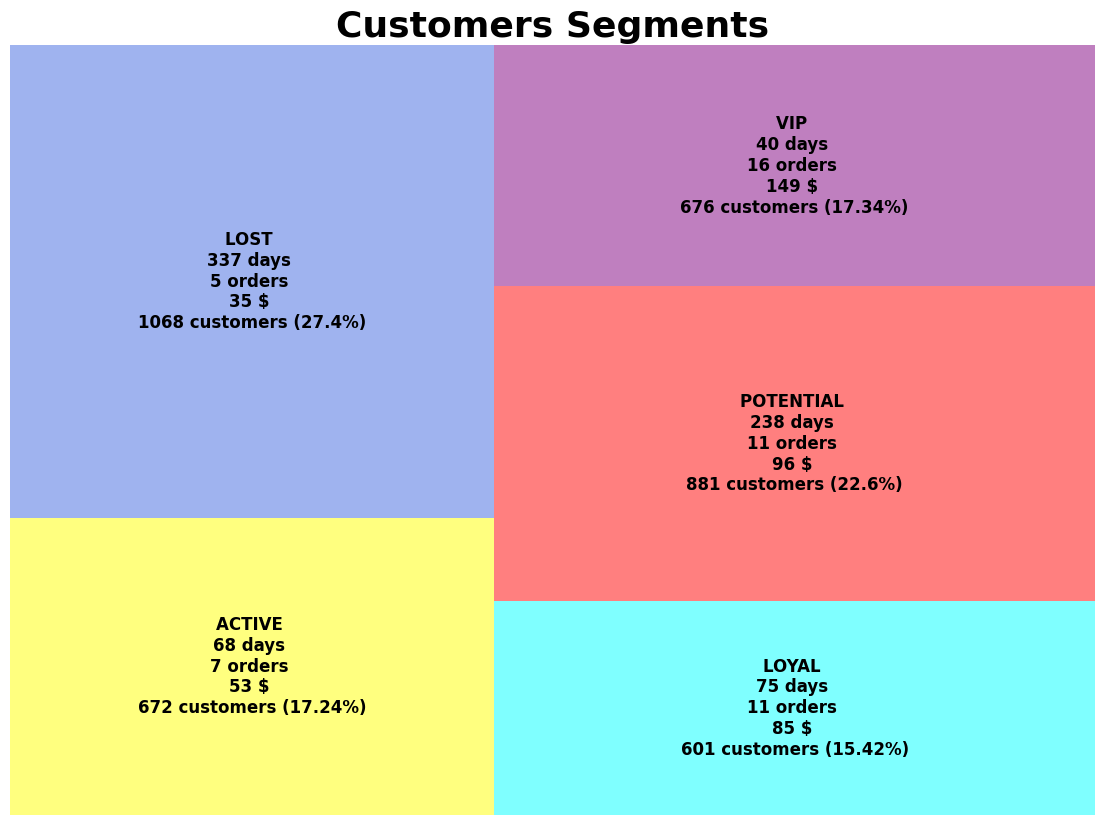

In [13]:
rfm_agg_pd = rfm_agg.toPandas()

# Create our plot and resize it
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'NEW':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_pd.iloc[i])
                      for i in range(0, len(rfm_agg_pd))], alpha=0.5 )

plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('outputs/RFM Segments (Pyspark).png')
plt.show()

In [14]:
import plotly.express as px

fig = px.scatter(rfm_agg_pd, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max = 60)
fig.show()

## KMeans
### Kmeans clusters with the Elbow Method

In [15]:
# Select the required columns
data_kmeans = data.select('Recency', 'Frequency', 'Monetary')

# Show the first few rows
data_kmeans.show(5)

+-------+---------+--------+
|Recency|Frequency|Monetary|
+-------+---------+--------+
|     91|       27|  361.45|
|     26|       25|   345.1|
|      4|       29|  334.15|
|      3|       30|  316.81|
|    142|       17|  312.46|
+-------+---------+--------+
only showing top 5 rows



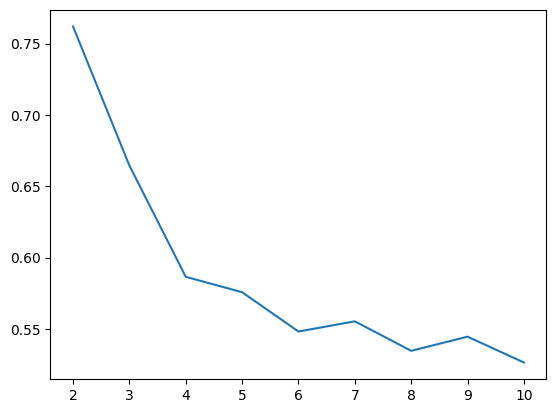

With k = 2- Silhouette = 0.7619558708181722
With k = 3- Silhouette = 0.6645514614502243
With k = 4- Silhouette = 0.5865495740267831
With k = 5- Silhouette = 0.5757584911180296
With k = 6- Silhouette = 0.5482165043760858
With k = 7- Silhouette = 0.555358179099408
With k = 8- Silhouette = 0.5346871943679183
With k = 9- Silhouette = 0.544607156891333
With k = 10- Silhouette = 0.5265235942804095



In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import ClusteringEvaluator

# Convert features to vector column
assembler = VectorAssembler(inputCols=['Recency', 'Frequency', 'Monetary'], outputCol='features')
data_with_features = assembler.transform(data_kmeans)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_with_features)
scaled_data = scaler_model.transform(data_with_features)

# Calculate SSE for different k values
k_list = []
silhouette_list = []
sil_str =''

for k in range(2, 11):
    kmeans = KMeans(k=k, seed=42, featuresCol='features')
    model = kmeans.fit(scaled_data)
    k_list.append(k)

    #silhouette
    predictions = model.transform(scaled_data)

    #Evaluate clistering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    
    sil_str = sil_str + 'With k = ' + str(k) + '- Silhouette = ' + str(silhouette) + '\n'

plt.plot(k_list, silhouette_list)
plt.show()
print(sil_str)

==> Chọn k = 5

#### Xây dựng mô hình với K = 5

In [17]:
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(scaled_data)

predictions = model.transform(scaled_data)

predictions.show(5)

+-------+---------+--------+-------------------+--------------------+----------+
|Recency|Frequency|Monetary|           features|     scaled_features|prediction|
+-------+---------+--------+-------------------+--------------------+----------+
|     91|       27|  361.45| [91.0,27.0,361.45]|[0.56906053559043...|         0|
|     26|       25|   345.1|  [26.0,25.0,345.1]|[0.16258872445440...|         0|
|      4|       29|  334.15|  [4.0,29.0,334.15]|[0.02501364991606...|         0|
|      3|       30|  316.81|  [3.0,30.0,316.81]|[0.01876023743704...|         0|
|    142|       17|  312.46|[142.0,17.0,312.46]|[0.88798457202023...|         0|
+-------+---------+--------+-------------------+--------------------+----------+
only showing top 5 rows



#### Đánh giá mô hình

==> Hiển thị dữ liệu theo cụm được dự đoán

In [18]:
selected_columns = ['Recency', 'Frequency', 'Monetary']

In [19]:
final_data = predictions.select('prediction', *selected_columns)

final_data.show(10)

+----------+-------+---------+--------+
|prediction|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|         0|     91|       27|  361.45|
|         0|     26|       25|   345.1|
|         0|      4|       29|  334.15|
|         0|      3|       30|  316.81|
|         0|    142|       17|  312.46|
|         4|    310|       20|  305.72|
|         0|    140|       24|  303.61|
|         0|     37|       30|  301.33|
|         0|     52|       23|   301.1|
|         0|    239|       15|  296.96|
+----------+-------+---------+--------+
only showing top 10 rows



In [20]:
predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  597|
|         1| 1047|
|         2|  327|
|         3| 1192|
|         4|  735|
+----------+-----+



# Phân tích kết quả phân cụm


In [21]:
pandas_df = final_data.toPandas()

In [22]:
predictions.groupBy('prediction').count().orderBy('prediction').show()
cluster_summary = pandas_df.groupby("prediction").mean()
cluster_summary

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  597|
|         1| 1047|
|         2|  327|
|         3| 1192|
|         4|  735|
+----------+-----+



,Recency,Frequency,Monetary
prediction,,,
0,63.768844,17.128978,175.854221
1,187.133715,9.492837,78.235425
2,551.455657,4.574924,37.846942
3,54.235738,9.600671,71.528389
4,343.790476,7.368707,63.121837


In [23]:
from pyspark.sql.functions import percentile_approx, count, round, sum, col, lit

# Calculate aggregations
rfm_agg2 = final_data.groupBy('prediction').agg(
    percentile_approx('Recency', 0.5).alias('RecencyMean'),
    percentile_approx('Frequency', 0.5).alias('FrequencyMean'),
    percentile_approx('Monetary', 0.5).alias('MonetaryMean'),
    count('*').alias('Count')
)

# Calculate total count for percentage
total_count = final_data.count()

# Add Percent column
rfm_agg2 = rfm_agg2.withColumn('Percent', 
    round(col('Count') * 100 / lit(total_count), 2))

rfm_agg2 = rfm_agg2.orderBy('prediction')
# Show results
rfm_agg2.show()

+----------+-----------+-------------+------------+-----+-------+
|prediction|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+----------+-----------+-------------+------------+-----+-------+
|         0|         56|           17|      162.74|  597|  15.32|
|         1|        185|            9|       72.85| 1047|  26.86|
|         2|        542|            4|       29.14|  327|   8.39|
|         3|         51|           10|        73.0| 1192|  30.58|
|         4|        339|            7|        57.0|  735|  18.86|
+----------+-----------+-------------+------------+-----+-------+



In [24]:
from pyspark.sql.functions import when

# Rename clusters based on their characteristics
rfm_agg2 = rfm_agg2.withColumn('prediction', 
    when(col('prediction') == 0, 'VIP')          # High frequency & monetary, recent activity
    .when(col('prediction') == 1, 'POTENTIAL')   # Medium values, not recent
    .when(col('prediction') == 2, 'LOST')        # Low values, very old activity
    .when(col('prediction') == 3, 'ACTIVE')      # Recent activity, medium values
    .when(col('prediction') == 4, 'INACTIVE')    # Old activity, low-medium values
    .otherwise(col('prediction')))

# Show updated results
rfm_agg2.show()

+----------+-----------+-------------+------------+-----+-------+
|prediction|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+----------+-----------+-------------+------------+-----+-------+
|       VIP|         56|           17|      162.74|  597|  15.32|
| POTENTIAL|        185|            9|       72.85| 1047|  26.86|
|      LOST|        542|            4|       29.14|  327|   8.39|
|    ACTIVE|         51|           10|        73.0| 1192|  30.58|
|  INACTIVE|        339|            7|        57.0|  735|  18.86|
+----------+-----------+-------------+------------+-----+-------+



| Cụm | Số lượng | Đặc trưng tiềm năng |
|-----|----------|----------------------|
| VIP | 597 | Phân khúc khách hàng trung bình (15.32%), có tần suất giao dịch cao nhất (17.0), chi tiêu cao nhất (162.74), và hoạt động gần đây nhất (56 ngày). Đây là nhóm khách hàng VIP, có giá trị cao và trung thành. |
| POTENTIAL | 1047 | Phân khúc lớn thứ hai (26.86%), tần suất giao dịch trung bình (9.0), chi tiêu trung bình (72.85), nhưng không hoạt động gần đây (185 ngày). Nhóm khách hàng tiềm năng cần được kích hoạt lại. |
| LOST | 327 | Phân khúc nhỏ nhất (8.39%), tần suất giao dịch thấp nhất (4.0), chi tiêu thấp nhất (29.14), và không hoạt động trong thời gian rất dài (542 ngày). Đây là nhóm khách hàng có nguy cơ mất hoặc đã rời bỏ. |
| ACTIVE | 1192 | Phân khúc lớn nhất (30.58%), tần suất giao dịch trung bình (10.0), chi tiêu trung bình (73.0), và hoạt động gần đây nhất (51 ngày). Đây là nhóm khách hàng phổ thông, ổn định và đang tích cực. |
| INACTIVE | 735 | Phân khúc trung bình (18.86%), tần suất giao dịch thấp (7.0), chi tiêu thấp (57.0), và không hoạt động trong thời gian dài (339 ngày). Nhóm khách hàng đang giảm dần sự gắn kết, cần chiến lược giữ chân. |

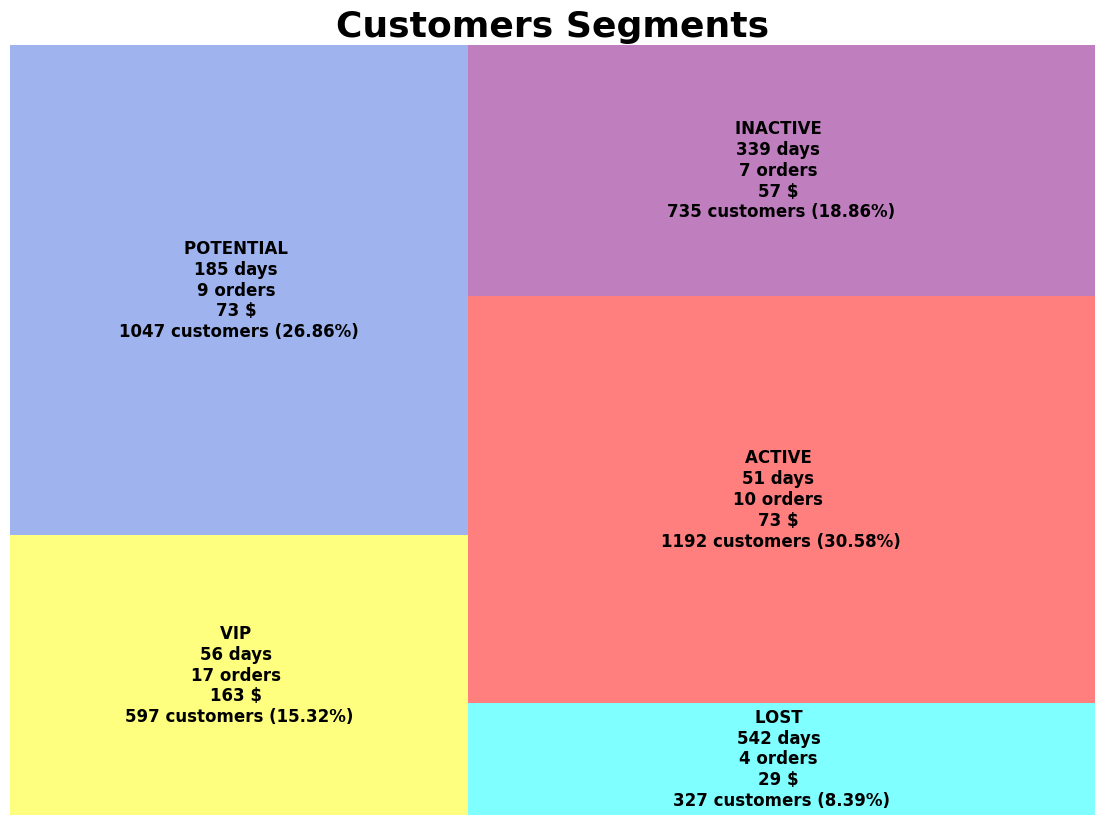

In [25]:
rfm_agg_pd2 = rfm_agg2.toPandas()

# Create our plot and resize it
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'0':'yellow','1':'royalblue', '2':'cyan',
               '3':'red', '4':'purple', '5':'green', '6':'gold'}

squarify.plot(sizes=rfm_agg_pd2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_pd2.iloc[i])
                      for i in range(0, len(rfm_agg_pd2))], alpha=0.5 )

plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('outputs/Kmeans Unsupervised Segments (Pyspark).png')
plt.show()

In [26]:
import plotly.express as px

fig = px.scatter(rfm_agg_pd2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="prediction",
           hover_name="prediction", size_max = 60) 

plt.savefig('outputs/Kmeans Unsupervised Segments Scatter (Pyspark).png')
fig.show()

<Figure size 640x480 with 0 Axes>

#### Trực quan hóa với biểu đồ 3 chiều

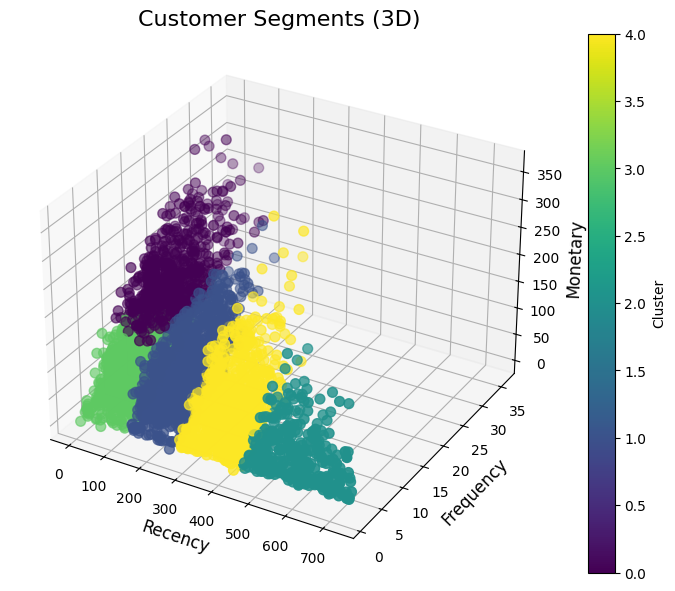

In [27]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pandas_df["Recency"], pandas_df["Frequency"], pandas_df["Monetary"], 
                     c=pandas_df["prediction"], cmap="viridis", s=50)

ax.set_title("Customer Segments (3D)", fontsize=16)
ax.set_xlabel("Recency", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_zlabel("Monetary", fontsize=12)

plt.colorbar(scatter, ax=ax, label="Cluster")
plt.savefig('outputs/Kmeans Unsupervised Segments Scatter 3D (Pyspark).png')
plt.show()